# MED-PC Extracting the Recording Data and Metadata

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from moviepy.editor import *
from datetime import datetime
from IPython.display import Video
from pathlib import Path

In [2]:
from medpc2excel.medpc_read import medpc_read
import cv2
import h5py
import numpy as np


In [3]:
# setting path
sys.path.append('../../README.mdsrc')

# Getting Tone Times

In [4]:
tone_start_df = pd.read_excel("./data/reward_comp_tone_sleap_frames.xlsx")

In [5]:
tone_start_df["File Name"] = tone_start_df["File Name"].apply(lambda x: x.split(".")[0])

In [6]:
tone_start_df["subj_1"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[0].replace("-", ".").strip())

In [7]:
tone_start_df["subj_2"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[1].replace("-", ".").strip())

In [8]:
tone_start_df["all_subj"] = tone_start_df.apply(lambda x: tuple(sorted([x["subj_1"], x["subj_2"]])) , axis=1)

In [9]:
tone_start_df = tone_start_df[tone_start_df["Frame Start"].astype(str).str.isnumeric()]

In [10]:
all_itis = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]

In [11]:
all_itis = [num * 30 for num in all_itis]

In [12]:
from functools import reduce

In [13]:
def get_running_total(lst):
    return reduce(lambda acc, x: acc + [acc[-1] + x] if acc else [x], lst, [])

In [14]:
tone_start_df["all_tone_frame"] = tone_start_df.apply(lambda row: get_running_total([row["Frame Start"]] + all_itis), axis=1)

In [15]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ..."
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ..."


In [16]:
all_corner_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/corner_labeling/*/*/*.corner.h5")

In [17]:
all_pose_estimation_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/h5/*/*/*.h5")

In [18]:
len(all_corner_h5)

33

In [19]:
len(all_pose_estimation_h5)

33

# Get Coordinates of all the corners

In [20]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [21]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [22]:
tone_start_df["corner_file"] = tone_start_df["File Name"].map(file_name_to_corner)
tone_start_df["pose_estimation_file"] = tone_start_df["File Name"].map(file_name_to_pose_estimation)

In [23]:
def get_sleap_coordinates(filename):
    """
    """
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    return locations, node_names, track_names

In [24]:
corner_node_names = get_sleap_coordinates(all_corner_h5[0])[1]

In [25]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

In [26]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [27]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[389.47144456886895, 548.2629792077062]","[512.0763306227065, 569.902165576138]","[637.5798522460396, 557.7260413970237]","[409.4781326203461, 254.70146395943902]","[643.5017427415908, 262.46446072195494]"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[348.83436667302124, 625.1914641653954]","[521.0751140419263, 658.3645972713236]","[692.7881935097188, 628.0072119332935]","[350.74679246264736, 214.02687569988802]","[695.0034616441534, 206.79059001184606]"


In [28]:
corner_columns = [col for col in tone_start_df.columns if "coordinates" in col]

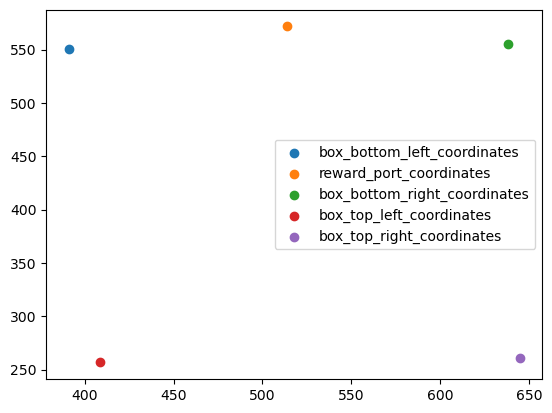

In [29]:
fig, ax = plt.subplots()

for index, row in tone_start_df.iterrows():
    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    break
plt.legend()

# Getting the distances between corners

In [30]:
tone_start_df["bottom_width"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
tone_start_df["top_width"] = tone_start_df.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [31]:
tone_start_df["right_height"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
tone_start_df["left_height"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [32]:
tone_start_df["average_height"] = tone_start_df.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
tone_start_df["average_width"] = tone_start_df.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

In [33]:
tone_start_df["width_ratio"] = 29.5 / tone_start_df["average_width"]
tone_start_df["height_ratio"] = 24 / tone_start_df["average_height"]


In [105]:
tone_start_df.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'subj_1', 'subj_2',
       'all_subj', 'all_tone_frame', 'corner_file', 'pose_estimation_file',
       'box_bottom_left_coordinates', 'reward_port_coordinates',
       'box_bottom_right_coordinates', 'box_top_left_coordinates',
       'box_top_right_coordinates', 'bottom_width', 'top_width',
       'right_height', 'left_height', 'average_height', 'average_width',
       'width_ratio', 'height_ratio', 'pose_estimation_subj_1_coordinates',
       'pose_estimation_subj_1_name', 'pose_estimation_subj_2_coordinates',
       'pose_estimation_subj_2_name',
       'pose_estimation_subj_1_original_coordinates',
       'pose_estimation_subj_1_scaled_coordinates',
       'pose_estimation_subj_2_original_coordinates',
       'pose_estimation_subj_2_scaled_coordinates',
       'pose_estimation_subj_1_thorax_coordinates',
       'pose_estimation_subj_2_thorax_coordinates'],
      dtype='object')

In [108]:
tone_start_df["reward_port_scaled"] = tone_start_df.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [109]:
tone_start_df["reward_port_scaled"]

0        [62.65767561559346, 46.6450642268789]
1      [44.79031206327622, 38.095121316373195]
2       [44.42939704940567, 35.56550022490564]
3      [62.66437903191042, 46.457593353668756]
4       [44.67155311688311, 37.96517782319081]
5       [43.48033926710607, 35.45305995884919]
6       [63.67403573088538, 47.18483629837384]
7      [43.50130361232485, 35.355649768653635]
8      [63.61830704527882, 47.078440172566104]
9       [64.53216327469285, 47.11044009374468]
10       [63.43516068508019, 47.6202483305839]
11       [62.85596760361868, 46.5217960004979]
12      [44.98362245572794, 37.64878595279556]
13      [65.42517992066077, 46.61455513415089]
14     [63.046091498234816, 46.91265128411644]
15      [63.55260453352851, 46.89055487864883]
17    [63.627820961484495, 45.886329355603685]
18     [43.099918367994746, 35.61912482253337]
19       [64.1506118178146, 47.81908162396559]
20    [44.148772051313195, 35.101527543757406]
21      [65.32806162465717, 47.14667016127896]
22      [44.6

In [110]:
43/35

1.2285714285714286

In [ ]:
64/

# Getting the coordinates of each mouse

In [58]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y


In [35]:
body_part_node_names = get_sleap_coordinates(all_pose_estimation_h5[0])[1]

In [36]:
body_part_node_names

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [95]:
def scale_coordinates(row, coordinate_col, height_ratio_col="height_ratio", width_ratio_col="width_ratio"):
    """
    """
#     return row[coordinate_col][:,:,0] * row[width_ratio_col]
    return np.dstack((row[coordinate_col][:,:,0] * row[width_ratio_col], row[coordinate_col][:,:,1] * row[height_ratio_col]))


In [96]:
scale_coordinates(tone_start_df.iloc[0], "pose_estimation_subj_{}_coordinates".format(num + 1))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [103]:
for num in range(2):
#     print(num)
    tone_start_df["pose_estimation_subj_{}_original_coordinates".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: fill_missing(get_sleap_coordinates(x)[0][:,:,:,num]))
    tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)] = tone_start_df.apply(lambda row: scale_coordinates(row, "pose_estimation_subj_{}_original_coordinates".format(num + 1)), axis=1)     
    tone_start_df["pose_estimation_subj_{}_thorax_coordinates".format(num + 1)] = tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)].apply(lambda x: x[:,4,:])
    tone_start_df["pose_estimation_subj_{}_name".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[2][num])


In [101]:
tone_start_df["pose_estimation_subj_2_scaled_coordinates"].iloc[0]

array([[[44.98479072, 23.19519288],
        [47.79990599, 22.86831704],
        [45.88192048, 22.8837195 ],
        [51.24990445, 24.75222728],
        [47.30615551, 24.14127755],
        [46.81418364, 23.19246352]],

       [[44.98479072, 23.19519288],
        [47.79990599, 22.86831704],
        [45.88192048, 22.8837195 ],
        [51.24990445, 24.75222728],
        [47.30615551, 24.14127755],
        [46.81418364, 23.19246352]],

       [[44.98479072, 23.19519288],
        [47.79990599, 22.86831704],
        [45.88192048, 22.8837195 ],
        [51.24990445, 24.75222728],
        [47.30615551, 24.14127755],
        [46.81418364, 23.19246352]],

       ...,

       [[61.39933578, 46.3596406 ],
        [58.52397427, 46.31947716],
        [59.50054304, 47.02976347],
        [60.92952602, 40.50325374],
        [60.50421907, 44.09899259],
        [59.54517236, 46.68110255]],

       [[60.9642464 , 46.65289749],
        [58.05635616, 46.35081003],
        [59.00208924, 47.65734218],
       

In [104]:
tone_start_df["pose_estimation_subj_2_thorax_coordinates"].iloc[0]

array([[47.30615551, 24.14127755],
       [47.30615551, 24.14127755],
       [47.30615551, 24.14127755],
       ...,
       [60.50421907, 44.09899259],
       [60.41302924, 44.37873217],
       [59.99075488, 44.36701285]])

In [102]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"] = 

KeyError: 'pose_estimation_subj_1_thorax_coordinates'

In [72]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]

array([[46.05535172, 45.69088242, 47.02495721, 41.80234988, 44.02782998,
        46.38170958],
       [46.05535172, 45.69088242, 47.02495721, 41.80234988, 44.02782998,
        46.38170958],
       [46.05535172, 45.69088242, 47.02495721, 41.80234988, 44.02782998,
        46.38170958],
       ...,
       [47.95933003, 47.33211491, 48.94409144, 42.15071695, 45.02749828,
        48.27934761],
       [47.97490432, 47.34905886, 48.96571216, 42.15758019, 45.04878032,
        48.29513606],
       [47.95988288, 47.34244963, 48.95777809, 42.14295719, 45.06227771,
        48.28021423]])

In [78]:
(tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]).shape

(55952, 6)

In [79]:
np.dstack((tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,0] * tone_start_df["width_ratio"].iloc[0], tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]))

array([[[63.45613955, 46.05535172],
        [60.91743287, 45.69088242],
        [61.95142737, 47.02495721],
        [67.36020434, 41.80234988],
        [64.29902872, 44.02782998],
        [61.95556509, 46.38170958]],

       [[63.45613955, 46.05535172],
        [60.91743287, 45.69088242],
        [61.95142737, 47.02495721],
        [67.36020434, 41.80234988],
        [64.29902872, 44.02782998],
        [61.95556509, 46.38170958]],

       [[63.45613955, 46.05535172],
        [60.91743287, 45.69088242],
        [61.95142737, 47.02495721],
        [67.36020434, 41.80234988],
        [64.29902872, 44.02782998],
        [61.95556509, 46.38170958]],

       ...,

       [[65.87689146, 47.95933003],
        [62.93663251, 47.33211491],
        [62.4652004 , 48.94409144],
        [66.34313654, 42.15071695],
        [65.8962033 , 45.02749828],
        [63.45734515, 48.27934761]],

       [[65.8565452 , 47.97490432],
        [62.93495063, 47.34905886],
        [62.42327994, 48.96571216],
       

In [66]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,:]

array([[[520.43615723, 564.39056396],
        [499.6149292 , 559.9241333 ],
        [508.09524536, 576.27270508],
        [552.4553833 , 512.27166748],
        [527.34912109, 539.54406738],
        [508.12918091, 568.38995361]],

       [[520.43615723, 564.39056396],
        [499.6149292 , 559.9241333 ],
        [508.09524536, 576.27270508],
        [552.4553833 , 512.27166748],
        [527.34912109, 539.54406738],
        [508.12918091, 568.38995361]],

       [[520.43615723, 564.39056396],
        [499.6149292 , 559.9241333 ],
        [508.09524536, 576.27270508],
        [552.4553833 , 512.27166748],
        [527.34912109, 539.54406738],
        [508.12918091, 568.38995361]],

       ...,

       [[540.28997803, 587.7230835 ],
        [516.17541504, 580.0368042 ],
        [512.30895996, 599.79095459],
        [544.1138916 , 516.54077148],
        [540.44836426, 551.7946167 ],
        [520.44604492, 591.64477539]],

       [[540.12310791, 587.91394043],
        [516.16162109, 580.24

3000: the number of frames;

13: the number of nodes in the skeleton (we’ve also loaded and displayed the node_names dataset with the names of these 13 nodes);

2: for the x and y coordinates;

2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn’t work as well).

In [43]:
tone_start_df["pose_estimation_subj_1"] = 
tone_start_df["pose_estimation_subj_1"] = 

,File Name,Frame Start,FPS,Strain,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file,...,box_top_left_coordinates,box_top_right_coordinates,bottom_width,top_width,right_height,left_height,average_height,average_width,width_ratio,height_ratio
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]",247.321004,236.568081,294.734211,293.487267,294.110739,241.944542,0.121929,0.081602
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]",342.749638,341.661867,417.016237,413.965974,415.491106,342.205752,0.086205,0.057763
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]",343.783067,332.030360,416.389258,422.533801,419.461529,337.906713,0.087302,0.057216
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[409.4781326203461, 254.70146395943902]","[643.5017427415908, 262.46446072195494]",248.108408,234.023610,295.261581,293.561515,294.411548,241.066009,0.122373,0.081519
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[350.74679246264736, 214.02687569988802]","[695.0034616441534, 206.79059001184606]",343.953827,344.256669,421.216622,411.164588,416.190605,344.105248,0.085730,0.057666
5,10-03-22_Test_15_1-2v1-4,2126,29,C57,1.2,1.4,"(1.2, 1.4)","[2126, 4526, 7226, 9626, 11876, 14876, 17726, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[335.7369198234354, 163.69767972487443]","[681.8205431807193, 168.68309070548707]",339.756243,346.083623,416.664879,418.345506,417.505192,342.919933,0.086026,0.057484
6,10-03-22_Test_16_1-1v1-3,2139,30,C57,1.1,1.3,"(1.1, 1.3)","[2139, 4539, 7239, 9639, 11889, 14889, 17739, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[415.5535386121701, 249.525195968645]","[647.132959791255, 263.65911117524]",246.486741,231.579421,289.049922,294.953153,292.001537,239.033081,0.123414,0.082191
7,10-03-22_Test_19_3-2v3-4,2090,30,C57,3.2,3.4,"(3.2, 3.4)","[2090, 4490, 7190, 9590, 11840, 14840, 17690, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[340.68756998880167, 167.2532278005665]","[685.4057773151325, 166.1950963161961]",340.326924,344.718207,423.632705,416.571631,420.102168,342.522565,0.086126,0.057129
8,10-03-22_Test_20_3-1v3-3,2100,30,C57,3.1,3.3,"(3.1, 3.3)","[2100, 4500, 7200, 9600, 11850, 14850, 17700, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[417.8521836506159, 251.79187150350435]","[648.5186962399791, 261.2638069045993]",246.978078,230.666513,292.778621,289.402775,291.090698,238.822295,0.123523,0.082449
9,10-04-22_Test_7_3-1v3-4,1838,30,C57,3.1,3.4,"(3.1, 3.4)","[1838, 4238, 6938, 9338, 11588, 14588, 17438, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,...,"[395.0785497668192, 253.33162865579595]","[639.9802127351343, 245.87396930717887

In [38]:
node_names

['4.4',
 '4.2',
 'track_24',
 'track_25',
 'track_479',
 'track_480',
 'track_1207',
 'track_1208']

In [39]:
tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

0     [nan, nan]
1     [nan, nan]
2     [nan, nan]
3     [nan, nan]
4     [nan, nan]
5     [nan, nan]
6     [nan, nan]
7     [nan, nan]
8     [nan, nan]
9     [nan, nan]
10    [nan, nan]
11    [nan, nan]
12    [nan, nan]
13    [nan, nan]
14    [nan, nan]
15    [nan, nan]
17    [nan, nan]
18    [nan, nan]
19    [nan, nan]
20    [nan, nan]
21    [nan, nan]
22    [nan, nan]
23    [nan, nan]
25    [nan, nan]
26    [nan, nan]
27    [nan, nan]
28    [nan, nan]
29    [nan, nan]
30    [nan, nan]
31    [nan, nan]
32    [nan, nan]
33    [nan, nan]
34    [nan, nan]
Name: pose_estimation_file, dtype: object

In [40]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

# Calculate Distance from Thorax to Reward Port

In [41]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [42]:
raise ValueError()

ValueError: 

- Calculating Horizontal and Vertical Distances

In [ ]:
tone_start_df["horizontal_length"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][])

In [ ]:
filename = all_corner_h5[0]

In [ ]:

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

In [ ]:
locations[0,1,0,0]

In [ ]:
locations[0,1,1,0]

In [ ]:
for index, row in tone_start_df.iterrows():
    print(row["corner_file"])
    

# Incorporating Winning and Losing

In [ ]:
rc_outcome_df = pd.read_excel("./data/iwata_pilot_3_reward_competition.xlsx")

In [ ]:
rc_outcome_df["subj_1"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[0])
rc_outcome_df["subj_2"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[1])
rc_outcome_df["all_subj"] = rc_outcome_df.apply(lambda x: tuple(sorted([x["subj_1"], x["subj_2"]])) , axis=1)

In [ ]:
rc_outcome_df

In [ ]:
rc_outcome_df["subj_1"].unique()

In [ ]:
rc_outcome_df["subj_1"].unique()